# Midterm Project: Eigenfaces

Solution

In [70]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_olivetti_faces
from skimage import transform as tf

import matplotlib.pyplot as plt

In [71]:
from sklearn.datasets import load_digits
digits = load_digits()
mnist_split_index = int(round(len(digits.images)/2))
mnist_train_images = np.zeros((mnist_split_index,64,64))
for i in range(0,mnist_split_index):
    mnist_train_images[i,:,:] = tf.resize(digits.images[i],(64,64))/16 #standardize the pixel values
mnist_train_labels = digits.target[:mnist_split_index]

mnist_test_images = np.zeros((len(digits.images)-mnist_split_index,64,64))
for i in range(0,len(digits.images)-mnist_split_index):
    mnist_test_images[i,:,:] = tf.resize(digits.images[i+mnist_split_index],(64,64))/16 #standardize
mnist_test_labels = digits.target[mnist_split_index:]

from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
faces_train_indices = np.random.choice(len(faces.images), int(len(faces.images)/2), replace=False) #choose images randomly for test/training
faces_split_index = int(round(len(faces.images)/2))
faces_train_images = faces.images[faces_train_indices]
faces_train_labels = faces.target[faces_train_indices]

faces_test_images = faces.images[~faces_train_indices]
faces_test_labels = faces.target[~faces_train_indices]

2) Using the training datasets, compute the mean for the face and digits datasets, denoted m_0 and m_1, respectively. Next, compute the empirical *covariance* matrix of each class, denoted K_0 and K_1; treating each image as a column vector x, the empirical covariance is found by averaging (x - m_i)*(x-m_i)^T for each class.

In [72]:
m_0 = np.mean(faces_train_images,0).flatten()
m_1 = np.mean(mnist_train_images,0).flatten()

w_0 = np.resize(faces_train_images,(-1,64*64)) - m_0
w_1 = np.resize(mnist_train_images,(-1,64*64)) - m_1

K_0 = w_0.T@w_0/len(w_0)
K_1 = w_1.T@w_1/len(w_1)

3) Eigenfaces uses the PCA method to model the images. Take the eigenvector-eigenvalue decomposition of each matrix, and let U_0 and U_1 denote the matrix of the top 10 eigenvectors of K_0 and K_1, respectively. Make sure that the columns are of unit norm, so that they form an orthonormal set.

In [73]:
k=10

l_0, V_0 = np.linalg.eigh(K_0)
l_1, V_1 = np.linalg.eigh(K_1)
U_0 = V_0[:,-k:]
U_1 = V_1[:,-k:]

4) Your face detector will use the likelihoods p(y|H0) = N(mu_0, U_0*U_0^T + sigma^2*I) and  p(y|H1) = N(mu_1, U_1*U_1^T + sigma^2*I). Derive the Neyman-Pearson detector for this problem using these likelihood functions for sigma^2 of your choice. Empirically compute the ROC curve by drawing 1000 samples from each distribution and computing P_FA and P_D.

In [111]:
sigma_2 = 50
P_0 = U_0@U_0.T + 1/sigma_2*np.eye(64*64) #covariance inverses
P_1 = U_1@U_1.T + 1/sigma_2*np.eye(64*64)

b = m_1.T@P_1 - m_0.T@P_0
S = (P_0 - P_1)

NUM_SAMPLES = 1000
NUM_THRESHOLDS = 20
P_FA = np.zeros(NUM_THRESHOLDS)
P_D = np.zeros(NUM_THRESHOLDS)
thresholds = np.linspace(-1000,1000,NUM_THRESHOLDS)
for j in range(0,NUM_THRESHOLDS):
    for i in range(0,NUM_SAMPLES):
        y_0 = m_0 + U_0@np.random.randn(k)  + np.sqrt(sigma_2)*np.random.randn(64*64)
        if(b@y_0 + 1/2*y_0.T@S@y_0 > thresholds[j]):
            P_FA[j] += 1/NUM_SAMPLES

        y_1 = m_1 + U_1@np.random.randn(k)  + np.sqrt(sigma_2)*np.random.randn(64*64)
        if(b@y_1 + 1/2*y_1.T@S@y_1 > thresholds[j]):
            P_D[j] += 1/NUM_SAMPLES


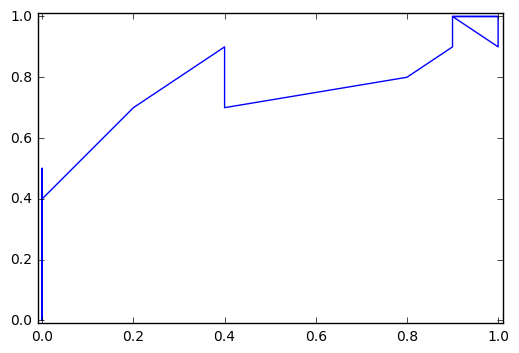

In [108]:
plt.plot(P_FA,P_D)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.show()

5) Now, use the *test* set to compute the ROC curve on real-world data. For each threshold, compute the empirical probability of false alarm and missed detection over the test images. Is this ROC curve the same as the one you computed in (4)? Why or why not?

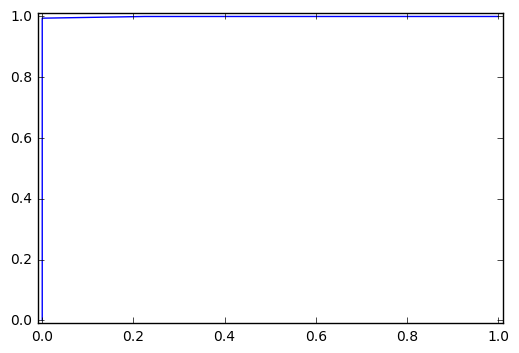

In [110]:
NUM_THRESHOLDS = 50
P_FA = np.zeros(NUM_THRESHOLDS)
P_D = np.zeros(NUM_THRESHOLDS)
thresholds = np.linspace(-1000,1000,NUM_THRESHOLDS)
for j in range(0,NUM_THRESHOLDS):
    for i in range(0,len(faces_test_images)):
        y_0 = faces_test_images[i].flatten()
        if(b@y_0 + 1/2*y_0.T@S@y_0 > thresholds[j]):
            P_FA[j] += 1/len(faces_test_images)
    for i in range(0,len(mnist_test_images)):
        y_1 = mnist_test_images[i].flatten()
        if(b@y_1 + 1/2*y_1.T@S@y_1 > thresholds[j]):
            P_D[j] += 1/len(mnist_test_images)

plt.plot(P_FA,P_D)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.show()

The ROC curves are rather different, because in this case I have added quite a bit of model noise. In practice the mean images are so different; even with lots of noise, the face images are very distinct from the digits.

PART II: Face recognition

1) Compute the mean of each *class*, where each individual has her/his own class. Denote these means m_i.

In [55]:
U = U_0
M = 40
m = np.zeros((M,64*64))
for i in range(0,40):
    indices = faces_train_labels == i
    images = np.resize(faces_train_images[indices],(-1,64*64))
    m[i,:] =  np.mean(images,0)

2) The classifier will use p(y|Hi) = N(m_i, U*U^T + sigma^2*I) as the likelihood functions. Determine the maximum-likelihood classifier in terms of m_i, sigma^2, and U. Specifically, find an explicit expression for the inverse of the covariance U*U^T + sigma^2*I. For sigma^2 = {1, 10, 100}, determine the *confusion matrix* over the test set, i.e. the probability that an image of class i is classified as class j.

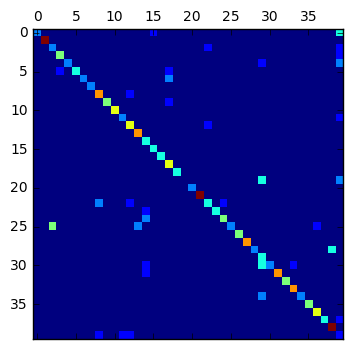

In [62]:
C = np.zeros((M,M))
sigma_2 = 1
P = U@U.T + 1/sigma_2*np.eye(64*64)

for i in range(0,len(faces_test_labels)):
    y = faces_test_images[i].flatten()
    llfs = np.zeros(M)
    for j in range(0,M):
        llfs[j] = -(y - m[j,:]).T@P@(y - m[j,:])
    label_estimate = np.argmax(llfs)
    C[faces_test_labels[i],label_estimate] += 1

plt.matshow(C)
plt.show()

3) Determine the form of the classifier in the limit of \sigma^2 -> 0. Suggest a simple interpetation of this classifier in terms of looking at each image in the "face space" spanned by the columns of U. This form is the Eigenface detector suggested above; it is an approximation of the statistical classifier that is optimum in the limit of small model noise. Compute the confusion matrix for this classifier. Is there much change in performance?

As \sigma^2 ->0, the inverse covariance is merely U\*U^T. So, the log-likelihood is proportional to (y - m_i)^T\*U\*U^T\*(y - m_i) = || U^T\*y - U^T\*m_i||^2. So, a simple detector is to compute the mean of each class in "face space":  u_i = U^T\*m_i, and then to compare the face space representation of the image to each of these means. This greatly accelerates the computational aspects of classification.

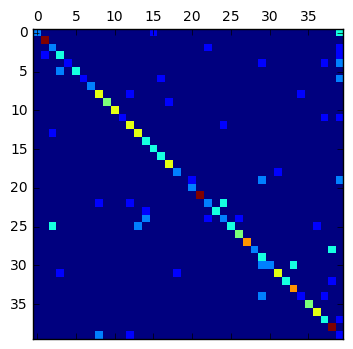

In [64]:
C = np.zeros((M,M))
u = (U.T@m.T).T
for i in range(0,len(faces_test_labels)):
    y = faces_test_images[i].flatten()
    projections = np.zeros(M)
    for j in range(0,M):
        projections[j] = np.linalg.norm(U.T@y - u[j,:])
    label_estimate = np.argmin(projections)
    C[faces_test_labels[i],label_estimate] += 1

plt.matshow(C)
plt.show()